In [1]:
#!/public/home/users/bio001/tools/python-2.7.11/bin/python
import matplotlib.pyplot as plt
import numpy as np
from numpy import *
import os
from matplotlib import colors, ticker, cm
from matplotlib.colors import ListedColormap
import h5py
import tensorflow as tf
from tensorflow.keras.models import load_model

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}

In [37]:
with h5py.File('data.h5', 'r') as hf:
    ta = hf['ta'][:]   # simulation time
    ina = hf['ina'][:]  # intensity (x 10^19), i.e. ina[0] = 1.43 is 1.43x10^19
    pla = hf['pla'][:]  # pulse length in fs
    n0a = hf['n0a'][:]  # target density in nc
    dLa = hf['dLa'][:]  # preplasma gradient length scale
    tha = hf['tha'][:]  # target thickness
    pra = hf['pra'][:]  # distance btw target and laser antenna, effectively size of sim. box
    ppa = hf['ppa'][:]  # particles-per-cell
    ena1 = hf['ena1'][:] # energy bins up to 10 MeV
    ena2 = hf['ena2'][:] # energy bins up to 20 MeV
    edM1 = hf['edM1'][:] # energy density
    edM2 = hf['edM2'][:] # energy density

In [46]:
model = load_model('model_s_2.h5')

In [13]:
def nd(data,ndt):  #normalize data
    if   ndt == 0:
        dataout = data/amax(data)
    elif ndt == 1:      #this seemed to work better for exponential/logarithmically uniform data
        dataout = log10(data+1)/amax(log10(data+1))   
    return array(dataout)

def rnd(data,data0,ndt):  #renormalize data
    if   ndt == 0:
        dataout = (data)*amax(data0)
    elif ndt == 1:
        dataout = 10**(data*amax(log10(data0+1)))-1  
    return array(dataout)

In [60]:
nt1 = 0  #normalization type
nt2 = 1
nt3 = 1

inp = vstack((ina,pla,n0a,dLa,tha,pra,ppa))
inpn = vstack((nd(ina,nt2),nd(pla,nt1),nd(n0a,nt1),nd(dLa,nt2),nd(tha,nt1),nd(pra,nt1),nd(ppa,nt1)))

In [78]:
# crude way to examine parameters you are interested in, e.g., for intensity > 9 [x1E19]
where(ina > 9)

(array([ 39, 112, 153, 167, 238, 262, 296], dtype=int64),)

intensity: 3.664e+19  W/cm2, pulse length: 109.73  fs, scale length: 0.50  um, thickness: 5.00 um,
  target density: 100.00 nc, simulation box:  50 um, particles-per-cell:  200
intensity: 5.792e+18  W/cm2, pulse length: 77.46  fs, scale length: 0.50  um, thickness: 5.00 um,
  target density: 100.00 nc, simulation box:  50 um, particles-per-cell:  200
intensity: 5.892e+18  W/cm2, pulse length: 34.33  fs, scale length: 0.50  um, thickness: 5.00 um,
  target density: 100.00 nc, simulation box:  50 um, particles-per-cell:  200
intensity: 1.538e+18  W/cm2, pulse length: 113.56  fs, scale length: 0.50  um, thickness: 5.00 um,
  target density: 100.00 nc, simulation box:  50 um, particles-per-cell:  200
intensity: 9.032e+19  W/cm2, pulse length: 132.73  fs, scale length: 0.50  um, thickness: 5.00 um,
  target density: 100.00 nc, simulation box:  50 um, particles-per-cell:  200


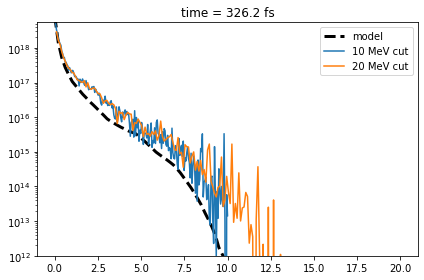

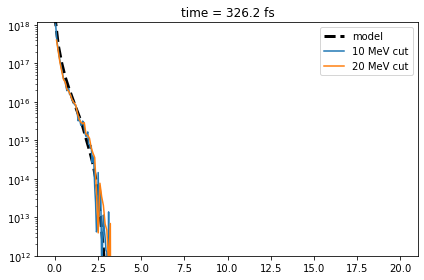

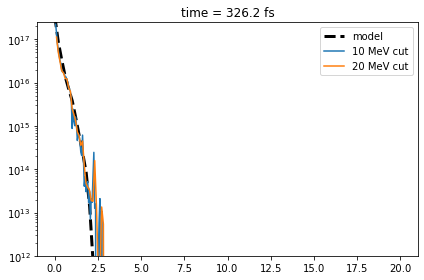

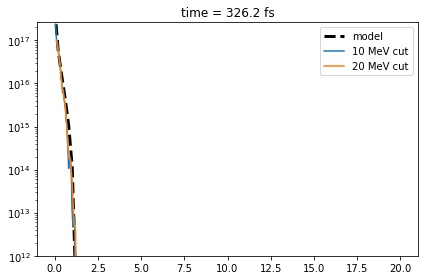

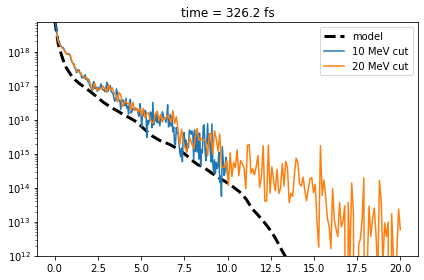

In [81]:
c = 2.998e8;
me = 9.10938356e-31
mp = 1.6727e-27
md = 3.3452438e-27  

# iS = 4     # simulation run
iT = 11    # simulation time (intervals of 33fs)

enmax = amax(array([amax(ena1),amax(ena2)]))
edmax = amax([amax(edM1.reshape(-1)),amax(edM2.reshape(-1))])
tnT = ta/amax(ta)
enT = linspace(0,1,100)

for iS in array([4,33,66,99,39]):  # sweep over several simulations

    inT = inpn[0,iS] ; plT = inpn[1,iS] ;  n0T = inpn[2,iS] ;     dLT = inpn[3,iS] ;    thT = inpn[4,iS] ;     prT = inpn[5,iS] ;    ppT = inpn[6,iS] ;
    ini = inp[0,iS] ; pli = inp[1,iS] ;  n0i = inp[2,iS] ;     dLi = inp[3,iS] ;    thi = inp[4,iS] ;     pri = inp[5,iS] ;    ppi = inp[6,iS] ;
    print('intensity: {:.3e}'.format(ini*1e19),' W/cm2, pulse length: {:.2f}'.format(pli),' fs, scale length: {:.2f}'.format(dLi),' um, thickness: {:.2f}'.format(thi),
         'um,\n  target density: {:.2f}'.format(n0i),'nc, simulation box: ',int(pri),'um, particles-per-cell: ',int(ppi))

    pT = zeros(len(enT))
    for i in range(len(pT)):
        pT[i] = model(np.asarray([[ tnT[iT], enT[i],  inT, plT, n0T, dLT, thT, prT, ppT ]]).astype(np.float32))[0]
    pT = rnd(pT,edmax,nt3)  

    plt.figure()
    plt.plot( enT*enmax,((pT)) ,'k--', label='model',linewidth=3) ;
    plt.plot(ena1, edM1[iT,:,iS],label='10 MeV cut')
    plt.plot(ena2, edM2[iT,:,iS],label='20 MeV cut')
    plt.title('time = {:.1f}'.format(ta[iT]*1e15)+' fs')
    plt.yscale('log')
#     plt.xlim([0,10])
    plt.ylim([1e12,1.1*amax(edM1[iT,:,iS])])
    plt.legend(); plt.tight_layout()